# Configuration
____________________

In [ ]:
# set main directories
BASE_DIR = '/content/gdrive/MyDrive/AML_project/project/'
UTILS_DIR = BASE_DIR + 'utils'
DATA_DIR = BASE_DIR + 'data/'
TOKENIZER_DIR = BASE_DIR + 'tokenizers/'
MODEL_DIR = BASE_DIR + 'models/'
PRED_DIR = BASE_DIR + 'predictions/'
# mount drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
# set utils directory
import sys
sys.path.append(UTILS_DIR)


Mounted at /content/gdrive


In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import *
from transformers import DistilBertTokenizerFast, DistilBertModel, DistilBertConfig
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras import metrics
from tensorflow.keras import layers
import pickle
from utils import train_val_split
from numpy.random import seed
from tensorflow import keras, random
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc, f1_score, precision_score, recall_score, multilabel_confusion_matrix

# utils
____________________

In [ ]:
def print_confusion_matrix(y_true, y_pred):
  print('\nConfusion matrices:')
  i = 0
  for cm in multilabel_confusion_matrix(y_true, y_pred, samplewise=False):
    if i != 0:
      print(labels[i])
    print(cm)
    i = i+1

labels = ['toxic', 'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']
labels_perf = ['Model', 'Performance', 'Value']

# Setup

In [ ]:
### SETTINGS ###
settings = {
      'RANDOM_STATE': 42,
      'EMBEDDING_CHOICE': 'fasttext', # 'fasttext', 'glove'
      'SOURCES': ['de', 'fr', 'es'], # ['de', 'fr', 'es', 'syn_0', 'syn_1', 'syn_2'], use [] to keep only original data 
      'TEST_SIZE': 0.2,
      'UNDERSAMPLE': False
}
# set seeds
seed(settings['RANDOM_STATE'])
random.set_seed(settings['RANDOM_STATE'])
# shortcut
labels = ['toxic', 'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']
targets = ['toxic', 'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate', 'is_toxic']

# Load data
____________________

In [ ]:
# load train
if settings['UNDERSAMPLE']:
  train = pd.read_csv(DATA_DIR + 'train_aug_und_cleaned.csv', sep='\t')
else:
  train = pd.read_csv(DATA_DIR + 'train_aug_cleaned.csv', sep='\t')

# load test
test = pd.read_csv(DATA_DIR + 'test_cleaned.csv', sep='\t')

# load test labels
test_labels = pd.read_csv(DATA_DIR + 'test_labels_cleaned.csv', sep='\t')

# Split in train and validaiton

In [ ]:
# split in train and validation
X_train_1, X_val_1, y_train_1, y_val_1 = train_val_split(X = train,
                                                          targets=targets,
                                                          val_size=settings['TEST_SIZE'],
                                                          random_state=settings['RANDOM_STATE'], 
                                                          sources=settings['SOURCES'])

y_train_1 = np.array(y_train_1['is_toxic'], dtype='int32')
y_val_1 = np.array(y_val_1['is_toxic'], dtype='int32')
X_test_1 = test['comment_text'] 
y_test_1 = np.array(test_labels['is_toxic'], dtype='int32')


Augmenting with de ...
Augmenting with fr ...
Augmenting with es ...


# Prepare input for bert model

In [ ]:
def bertTokenize(docs, tokenizer):
  input_ids = []
  attention_masks = []
  for doc in docs:
    bert_inp = tokenizer.encode_plus(doc, add_special_tokens = True, max_length = 100, padding = 'max_length', return_attention_mask = True, truncation=True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])
  return np.array(input_ids, dtype='int32'), np.array(attention_masks, dtype='int32')

Load tokenizer from the pretrained distilbert model

In [ ]:
bert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

In [ ]:
# tokenize train comments
input_ids_train, attention_masks_train = bertTokenize(X_train_1.values, bert_tokenizer)

In [ ]:
# tokenize validation comments
input_ids_val, attention_masks_val = bertTokenize(X_val_1.values, bert_tokenizer)

In [ ]:
# tokenize test comments
input_ids_test, attention_masks_test = bertTokenize(X_test_1.values, bert_tokenizer)

# Bert based model

## Create Model

Define DistilBert configuration

In [ ]:
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False

Load pretrained bert model

In [ ]:
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Transfer learning of Bert model

In [ ]:
# define inputs
input_ids_in = Input(shape=(100,), name='input_token', dtype='int32')
input_masks_in = Input(shape=(100,), name='masked_token', dtype='int32')

# define embedding layer with Bert weights
embedding_layer = bert_model.distilbert([input_ids_in, input_masks_in])[0]

# define lstm layer
lstm_layer = Bidirectional(LSTM(50, return_sequences=True, dropout=0.2))(embedding_layer)
# flatten with global max pool
pool = GlobalMaxPool1D()(lstm_layer)
# fully connected layers
dense = Dense(50, activation='relu')(pool)
dropout = tf.keras.layers.Dropout(0.2)(dense)

# define output layer
output = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=[input_ids_in, input_masks_in], outputs = output)

Freeze layers of the pretrained Bert model

In [ ]:
for layer in model.layers[:3]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=[metrics.Precision(), 'accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
distilbert (TFDistilBertMainLay TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 100)     327600      distilbert[0][0]             

## Train

In [ ]:
history = model.fit([input_ids_train,attention_masks_train], y_train_1, batch_size=256, epochs=20, 
                    callbacks=callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                    validation_data=([input_ids_val,attention_masks_val], y_val_1))

Epoch 1/20
650/650 [==============================] - 402s 594ms/step - loss: 0.3179 - precision: 0.8099 - accuracy: 0.8607 - val_loss: 0.2070 - val_precision: 0.8730 - val_accuracy: 0.9137
Epoch 2/20
650/650 [==============================] - 385s 592ms/step - loss: 0.2199 - precision: 0.8775 - accuracy: 0.9103 - val_loss: 0.1866 - val_precision: 0.8669 - val_accuracy: 0.9225
Epoch 3/20
650/650 [==============================] - 385s 593ms/step - loss: 0.2027 - precision: 0.8842 - accuracy: 0.9170 - val_loss: 0.1699 - val_precision: 0.8901 - val_accuracy: 0.9297
Epoch 4/20
650/650 [==============================] - 385s 592ms/step - loss: 0.1859 - precision: 0.8928 - accuracy: 0.9250 - val_loss: 0.1643 - val_precision: 0.8721 - val_accuracy: 0.9314
Epoch 5/20
650/650 [==============================] - 385s 593ms/step - loss: 0.1794 - precision: 0.8923 - accuracy: 0.9266 - val_loss: 0.1525 - val_precision: 0.9166 - val_accuracy: 0.9384
Epoch 6/20
650/650 [==============================

## Evaluation

Plot learning curves

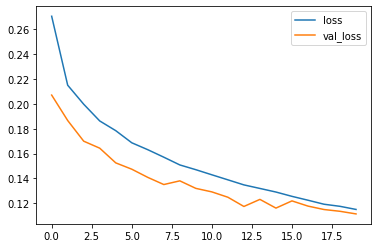

In [ ]:
pd_history_binary = pd.DataFrame(history.history)
pd_history_binary.plot(y=['loss', 'val_loss'])

Make predictions on the test set

In [ ]:
y_scores_binary = model.predict([input_ids_test, attention_masks_test])

Assign binary value to each label to compute accuracy

In [ ]:
threshold = 0.5
y_pred_binary = [[1 if label >= threshold else 0 for label in score] for score in y_scores_binary]

Measure the performance of the model

In [ ]:
print('Accuracy (vector of labels must match):', round(accuracy_score(y_test_1, y_pred_binary), 5))
print('ROC AUC:', round(roc_auc_score(y_test_1, y_scores_binary, average='macro'), 5))
print('Precision:', round(precision_score(y_test_1, y_pred_binary, average='macro'), 5))
print('Recall:', round(recall_score(y_test_1, y_pred_binary, average='macro'), 5))
print('F1 score:', round(f1_score(y_test_1, y_pred_binary, average='macro'), 5))
confusion_matrix(y_test_1, y_pred_binary)

Accuracy (vector of labels must match): 0.87169
ROC AUC: 0.9589
Precision: 0.70982
Recall: 0.89516
F1 score: 0.75508


array([[49597,  7678],
       [  472,  5770]])

## Save model and prediction

In [ ]:
# save model
model.save(MODEL_DIR + 'bert_bin.h5')
# save predictions
y_pred_binary = pd.DataFrame(y_pred_binary, columns=['is_toxic'])
y_pred_binary.to_csv(PRED_DIR + 'bert_bin.csv', index=False, sep='\t')